<a href="https://colab.research.google.com/github/Shopping-Yuan/ML2021HW/blob/Shopping_vscode_branch/HW12/HW12_DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Setting



###Install Package



In [1]:
!apt update
!apt install python3-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install swig
!pip install gym[box2d]
!pip install tqdm
!pip install box2d-kengz

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:6 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [805 kB]
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 Packages [44.7 kB]
Get:13 http://security.u

###Set Seed

In [2]:
import torch
import numpy as np
import random
seed = 543
def fix(env, seed):
  env.seed(seed)
  env.action_space.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  np.random.seed(seed)
  random.seed(seed)
  # torch.use_deterministic_algorithms(True)
  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.deterministic = True

###Pretrain

In [3]:
import torch.nn as nn
import torch.nn.functional as F
class PolicyGradientNetwork(nn.Module):

    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(8, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc2_2 = nn.Linear(16, 16)
        self.fc2_3 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 4)

    def forward(self, state):
        hid = torch.tanh(self.fc1(state))
        hid = torch.tanh(self.fc2(hid))
        hid = torch.tanh(self.fc2_2(hid))
        hid = torch.tanh(self.fc2_3(hid))
        return self.fc3(hid)

In [4]:
import torch.optim as optim
from torch.distributions import Categorical
class PolicyGradientAgent():

    def __init__(self, network):
        self.network = network
        self.optimizer = optim.SGD(self.network.parameters(), lr=0.001)

    # def forward(self, state):
    #     return self.network(state)
    def learn(self, log_probs, rewards):

        loss = (-log_probs * rewards).sum()

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def sample(self, state):
        action_prob = F.softmax(self.network(torch.FloatTensor(state)), dim=-1)
        action_dist = Categorical(action_prob)
        action = action_dist.sample()
        log_prob = action_dist.log_prob(action)
        return action.item(), log_prob

    def save(self, PATH): # You should not revise this
        Agent_Dict = {
            "network" : self.network.state_dict(),
            "optimizer" : self.optimizer.state_dict()
        }
        torch.save(Agent_Dict, PATH)

    def load(self, PATH): # You should not revise this
        checkpoint = torch.load(PATH)
        self.network.load_state_dict(checkpoint["network"])
        #如果要儲存過程或是中斷訓練後想繼續可以用喔 ^_^
        self.optimizer.load_state_dict(checkpoint["optimizer"])

In [5]:
from tqdm.notebook import tqdm
def policy_gradient_training(env,agent):
    agent.network.train()  # 訓練前，先確保 network 處在 training 模式
    EPISODE_PER_BATCH = 5  # 每蒐集 5 個 episodes 更新一次 agent
    NUM_BATCH = 400       # 總共更新 400 次

    avg_total_rewards, avg_final_rewards = [], []

    prg_bar = tqdm(range(NUM_BATCH))
    for batch in prg_bar:

        log_probs, rewards = [], []
        total_rewards, final_rewards = [], []

        # 蒐集訓練資料
        for episode in range(EPISODE_PER_BATCH):

            state = env.reset()
            total_reward, total_step = 0, 0
            seq_rewards = []
            while True:

                action, log_prob = agent.sample(state) # at(int) , log(at|st)
                next_state, reward, done, _ = env.step(action)

                log_probs.append(log_prob) # [log(a1|s1), log(a2|s2), ...., log(at|st)]
                state = next_state
                total_reward += reward
                total_step += 1

                seq_rewards.append(0)
                len_of_seq_reward = len(seq_rewards)
                seq_rewards = [seq_rewards[index] +(0.99)**(len_of_seq_reward-(index+1))\
                        *reward for index in range(len_of_seq_reward)]
                if done:
                    rewards+=seq_rewards
                    final_rewards.append(reward)
                    total_rewards.append(total_reward)
                    break

    print(f"rewards looks like ", np.shape(rewards))
    print(f"log_probs looks like ", np.shape(torch.tensor(log_probs)))
    # 紀錄訓練過程
    avg_total_reward = sum(total_rewards) / len(total_rewards)
    avg_final_reward = sum(final_rewards) / len(final_rewards)
    avg_total_rewards.append(avg_total_reward)
    avg_final_rewards.append(avg_final_reward)
    prg_bar.set_description(f"Total: {avg_total_reward: 4.1f}, Final: {avg_final_reward: 4.1f}")

    # 更新網路
    # rewards = np.concatenate(rewards, axis=0)
    rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-9)  # 將 reward 正規標準化
    agent.learn(torch.stack(log_probs), torch.from_numpy(rewards))
    print("logs prob looks like ", torch.stack(log_probs).size())
    print("torch.from_numpy(rewards) looks like ", torch.from_numpy(rewards).size())

In [6]:
# def get_pretrain_data(env,agent,buffer):
#   PRETRAIN_EPISON = 400
#   prg_bar = tqdm(range(PRETRAIN_EPISON))
#   total_state_action = []
#   total_seq_rewards = []
#   transition = namedtuple('transition_calss',('state', 'action', 'next_state', 'reward'))
#   for episode in prg_bar:
#       state = env.reset()
#       seq_rewards = []
#       seq_state = []
#       seq_action = []
#       datas = []
#       done = False
#       while not done:
#           action = env.action_space.sample()
#           seq_state.append(state)
#           action, _ = agent.sample(state)
#           action_one_hot = [0.,0.,0.,0.]
#           action_one_hot[int(action)] += 1.
#           seq_action.append(action_one_hot)
#           next_state, reward, done, _ = env.step(action)
#           datas.append(transition(state,action,next_state,reward))
#           seq_rewards.append(0)
#           len_of_seq_reward = len(seq_rewards)
#           seq_rewards = [seq_rewards[index] +(0.99)**(len_of_seq_reward-(index+1))\
#                   *reward for index in range(len_of_seq_reward)]

#           state = next_state

#       if seq_rewards[-1] > 0 :
#         for data in datas:
#           buffer.to_memory(data)
#         seq_state_action = \
#         [np.ndarray.tolist(seq_state[i])+seq_action[i] for i in range(len(seq_state))]
#         total_state_action+=seq_state_action
#         total_seq_rewards+=seq_rewards

#   return torch.FloatTensor(total_state_action),torch.FloatTensor(total_seq_rewards)

In [7]:
# from torch.utils.data import Dataset, DataLoader
# class Pretrain_Dataset(Dataset):
#   def __init__(self,data,label):
#     self.data = data
#     self.label = label
#   def __len__(self):
#     return len(self.data)

#   def __getitem__(self, index):
#     return self.data[index], self.label[index]
# def prep_dataloader(dataset,batch_size):
#   dataloader = DataLoader(
#         dataset, batch_size,
#         shuffle=True, drop_last=False,
#         num_workers=0, pin_memory=False)
#   return dataloader


In [8]:
import gym
def main_pre_train(BUFFER_SIZE):
  buffer = Buffer(BUFFER_SIZE)
  network = PolicyGradientNetwork()
  agent = PolicyGradientAgent(network)
  env = gym.make('LunarLander-v2')
  fix(env, seed)
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  policy_gradient_training(env,agent)

  # data,label = get_pretrain_data(env,agent,buffer)
  # train_loader = prep_dataloader(Pretrain_Dataset(data,label),100)
  # prg_bar = tqdm(train_loader)

  # model = Q_Network()
  # model = model.to(device)
  # optimizer = optim.AdamW(model.parameters(), lr=1e-4, amsgrad=True)
  # for i in range(500):
  #   for batch in prg_bar:
  #     input,label = batch
  #     input = input.to(device)
  #     label = label.to(device)
  #     output = model(input)
  #     loss = nn.MSELoss(reduction='mean')(output,label)

  #     optimizer.zero_grad()
  #     loss.backward()
  #     optimizer.step()

  torch.save(agent.network.state_dict(), "/content/pretrain_model.pth")
  print(f"There are {buffer.__len__()} datas in biffer.")
  return buffer


In [77]:
# main_pre_train(128)

「環境」給予的 reward 大致是這樣計算：
- 小艇墜毀得到 -100 分
- 小艇在黃旗幟之間成功著地則得 100~140 分
- 噴射主引擎（向下噴火）每次 -0.3 分
- 小艇最終完全靜止則再得 100 分
- 小艇每隻腳碰觸地面 +10 分
- 噴射左或右引擎（順時針或逆時針旋轉）每次 -0.03 分

In [10]:
import random
from collections import deque
class Buffer():
  def __init__(self, capacity):
      self.memory = deque([], maxlen=capacity)
  def to_memory(self, new_data):
      self.memory.append(new_data)
  def __len__(self):
      return len(self.memory)
  def sample_batch(self, batch_size):
      return random.sample(self.memory, batch_size)
# test
# dq = deque([], 10)
# for i in range(20):
#     dq.append(i)
#     print(dq)

In [12]:
import torch.nn as nn
import torch.nn.functional as F
class Q_Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(8, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc2_2 = nn.Linear(16, 16)
        self.fc2_3 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 4)

    def forward(self, state):
        hid = torch.tanh(self.fc1(state))
        hid = torch.tanh(self.fc2(hid))
        hid = torch.tanh(self.fc2_2(hid))
        hid = torch.tanh(self.fc2_3(hid))
        return self.fc3(hid)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


###Training

In [22]:
import matplotlib
import matplotlib.pyplot as plt
from IPython import display
import gym
import math
import torch.optim as optim
from torch.distributions import Categorical
from collections import namedtuple

class Q_Learning_Process():
    def __init__(self, env, device, policy_net, target_net, buffer):
        self.env = env
        self.device = device
        self.policy_net = policy_net.to(self.device)
        self.target_net = target_net.to(self.device)
        self.buffer = buffer

    def _exploration(self,steps_done,state,EPS_START,EPS_END,EPS_DECAY):
        sample = random.random()
        eps_threshold = EPS_END + (EPS_START - EPS_END) * \
            math.exp(-1. * steps_done / EPS_DECAY)
        if sample > eps_threshold:
            with torch.no_grad():
              input = torch.FloatTensor(state).unsqueeze(0).to(self.device)
              return self.policy_net(input).max(1).indices.detach().item()
              # input = torch.FloatTensor(state).unsqueeze(0).to(self.device)
              # action_one_hot = F.one_hot(torch.arange(0, 4))
              # input = torch.cat((input.repeat(4,1),action_one_hot.to(self.device)),dim = 1)
              # return self.policy_net(input).max(0).indices.detach().item()
        else:
          return self.env.action_space.sample()

    def update_buffer(self,state,done,steps_done,EPS_START,EPS_END,EPS_DECAY):
        transition = namedtuple('transition_calss',('state', 'action', 'next_state', 'reward'))
        action = self._exploration(steps_done, state,EPS_START,EPS_END,EPS_DECAY)
        next_state, reward, done, info = self.env.step(action)
        if not done:
          data = transition(state,action,next_state,reward)
          self.buffer.to_memory(data)
        steps_done += 1
        return reward,next_state,done,steps_done

    def optimize_model(self, optimizer, LR, BATCH_SIZE, GAMMA):
        self.policy_net.train()
        batch = self.buffer.sample_batch(BATCH_SIZE)
        state = torch.FloatTensor([d.state for d in batch]).to(self.device)
        action = torch.LongTensor([d.action for d in batch]).view(-1,1).to(self.device)
        next_state = torch.FloatTensor([d.next_state for d in batch]).to(self.device)
        reward = torch.FloatTensor([d.reward for d in batch]).to(self.device)
        out = self.policy_net(state)
        # print(out.shape)
        Q = out.gather(1,action)
        # action_one_hot = F.one_hot(action,num_classes = 4).squeeze(1)
        # Q_in = torch.cat((state,action_one_hot),dim = 1)
        # Q = self.policy_net(Q_in)

        with torch.no_grad():
          Q_next_max = self.target_net(next_state).max(1).values

        # repeat = torch.full([BATCH_SIZE],fill_value = 4).to(self.device)
        # next_state_expand = torch.repeat_interleave(next_state,repeat,dim=0)
        # action_one_hot_expand = F.one_hot(torch.arange(0, 4)).repeat(BATCH_SIZE,1).to(self.device)
        # Q_next_in = torch.cat((next_state_expand,action_one_hot_expand),dim =1)
        # Q_next_out = self.target_net(Q_next_in)
        # Q_next_out = Q_next_out.view(BATCH_SIZE,4)
        # Q_next_max =  Q_next_out.max(1).values
        criterion = nn.SmoothL1Loss()
        loss = criterion(Q,(reward + GAMMA*Q_next_max).unsqueeze(1))
        # loss = nn.MSELoss(reduction='mean')(Q,(reward + GAMMA*Q_next_max).unsqueeze(1))

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 100)
        optimizer.step()
        return loss

    def eval(self,EPISODE_PER_BATCH):
        total_rewards = []
        final_rewards = []
        for e in range(EPISODE_PER_BATCH):
          rewards = 0
          done = False
          state = self.env.reset()
          while not done:
            input = torch.FloatTensor(state).unsqueeze(0).to(self.device)
            # input = input.repeat(4,1)
            # action_one_hot = F.one_hot(torch.arange(0, 4)).to(self.device)
            # input = torch.cat((input,action_one_hot),dim =1)
            # action = \
            # self.target_net(input).max(0).indices.detach().item()
            action = \
            self.target_net(input).max(1).indices.detach().item()

            next_state, reward, done, info = self.env.step(action)
            rewards += reward

            if done:
              total_rewards.append(rewards)
              final_rewards.append(reward)
            state = next_state

        return sum(total_rewards)/len(total_rewards),\
            sum(final_rewards)/len(total_rewards)
    def soft_update(self,TAU):
      agent_target_net_state_dict = self.target_net.state_dict()
      agent_policy_net_state_dict = self.policy_net.state_dict()
      for key in agent_policy_net_state_dict:
          agent_target_net_state_dict[key] = \
          agent_policy_net_state_dict[key]*TAU + agent_target_net_state_dict[key]*(1-TAU)
      self.target_net.load_state_dict(agent_target_net_state_dict)

    def save(self, optimizer, PATH):
        Model_Dict = {
            "policy_net" : self.policy_net.state_dict(),
            "target_net" : self.target_net.state_dict(),
            "optimizer" : optimizer.state_dict(),
        }
        torch.save(Model_Dict, PATH)

    def load(self, optimizer, PATH):
        checkpoint = torch.load(PATH)
        self.policy_net.load_state_dict(checkpoint["policy_net"])
        self.target_net.load_state_dict(checkpoint["target_net"])
        optimizer.load_state_dict(checkpoint["optimizer"])
        return optimizer

In [14]:
def plot_data(is_ipython,loss,train_total_rewards,train_final_rewards,eval_total_rewards,eval_final_rewards):
  plt.clf()

  plt.figure(1)

  plt.title("Train")
  index = list(range(len(train_total_rewards)))
  plt.plot(index, train_total_rewards, c='tab:cyan', label='total rewards')
  plt.plot(index, train_final_rewards, c='tab:red', label='final rewards')
  plt.xlabel('Batch')
  plt.ylabel('Reward')
  plt.ylim(-300,200)
  if is_ipython:
    display.display(plt.gcf())

  plt.figure(2)

  plt.title("Eval")
  index = list(range(len(eval_total_rewards)))
  plt.plot(index, eval_total_rewards, c='tab:cyan', label='total rewards')
  plt.plot(index, eval_final_rewards, c='tab:red', label='final rewards')
  plt.xlabel('Batch')
  plt.ylabel('Reward')
  if is_ipython:
    display.display(plt.gcf())

  plt.figure(3)

  plt.title("Loss")
  index = list(range(len(loss)))
  plt.plot(index, loss, c='tab:cyan', label='total rewards')
  plt.xlabel('Batch')

  if is_ipython:
    display.display(plt.gcf())
    display.clear_output(wait=True)

In [66]:
# reference : https://nlp.seas.harvard.edu/2018/04/03/attention.html
class LR_Scheduler():
    def __init__(self,LR,optimizer):
        self.LR = LR
        self.optimizer = optimizer
        self._step = 0
        self._rate = 0
    def step(self):
        self._step += 1
        if self._step<=200:
          self._rate = self.LR
        else:
          self._rate = self.LR * \
          (self._step-200) ** (-0.5)

        self.optimizer.param_groups[0]["lr"] = self._rate
        self.optimizer.step()
    def zero_grad(self):
        return self.optimizer.zero_grad()

    def state_dict(self):
        return self.optimizer.state_dict()

    def load_state_dict(self,state_dict):
        return self.optimizer.load_state_dict(state_dict)

    def set_step(self,step):
        self._step = step

In [61]:
from tqdm.notebook import tqdm
import csv
import time

def train_eval(is_ipython,
        env,
        device,
        LOAD,
        MODEL_PATH,
        TRAIN_REWARD_PATH,
        EVAL_REWARD_PATH,
        LOSS_PATH,
        SAVE_EPISODE,
        BUFFER_SIZE,
        LR,
        NUM_EPISODE,
        GAMMA,
        TAU,
        EPS_START,
        EPS_END,
        EPS_DECAY,
        BATCH_SIZE):
  start = time.time()

  buffer = Buffer(BUFFER_SIZE)
  # buffer = main_pre_train(BUFFER_SIZE)
  agent = Q_Learning_Process(env,device,Q_Network(),Q_Network(),buffer)

  # agent.policy_net.load_state_dict(torch.load("/content/pretrain_model.pth"))
  agent.target_net.load_state_dict(agent.policy_net.state_dict())

  train_total_rewards = []
  train_final_rewards = []
  eval_total_rewards = []
  eval_final_rewards = []
  avg_loss = []

  with open(TRAIN_REWARD_PATH, 'w') as f:
      writer = csv.writer(f)
      writer.writerow(['total_reward', 'final_reward'])
  with open(EVAL_REWARD_PATH, 'w') as f:
      writer = csv.writer(f)
      writer.writerow(['total_reward', 'final_reward'])

  steps_done = 0

  optimizer = LR_Scheduler(LR,optim.AdamW(agent.policy_net.parameters(), lr=LR, amsgrad=True))
  if LOAD :
    optimizer = agent.load(optimizer,MODEL_PATH)
    print(f"Load model from {MODEL_PATH}")

  prg_bar = tqdm(range(NUM_EPISODE))

  for episode_index in prg_bar:
    rewards = 0
    state = env.reset()
    done = False
    loss = []
    while not done :
      reward,next_state,done,steps_done = \
      agent.update_buffer(state,done,steps_done,EPS_START,EPS_END,EPS_DECAY)
      state = next_state
      rewards += reward

      if agent.buffer.__len__()>= BATCH_SIZE:
        now_loss = agent.optimize_model(optimizer,LR,BATCH_SIZE,GAMMA).detach().item()
        loss.append(now_loss)

        agent.soft_update(TAU)

    if len(loss)>0:
      avg_loss.append(sum(loss) / len(loss) )
    train_total_rewards.append(rewards)
    train_final_rewards.append(reward)


    if (episode_index+1) % SAVE_EPISODE ==0:
      # agent.target_net.load_state_dict(agent.policy_net.state_dict())
      # save model
      agent.save(optimizer,MODEL_PATH)
      print(f"Save model from {episode_index+1}th batch to {MODEL_PATH}")

      # save train reward
      total_rewards = list(zip(train_total_rewards,train_final_rewards))
      total_rewards = total_rewards[episode_index+1-SAVE_EPISODE:episode_index+1]
      with open(TRAIN_REWARD_PATH, 'a') as f:
        writer = csv.writer(f)
        writer.writerows(total_rewards)
      print(f"Save policy rewards from {(episode_index+2)-SAVE_EPISODE}th"+
         f"to {episode_index+1}th batchs to {TRAIN_REWARD_PATH}")

      # do eval and save eval reward
      eval_total_reward, eval_final_reward = agent.eval(5)
      eval_total_rewards.append(eval_total_reward)
      eval_final_rewards.append(eval_final_reward)

      with open(EVAL_REWARD_PATH, 'a') as f:
        writer = csv.writer(f)
        writer.writerow([eval_total_reward,eval_final_reward])

      print(f"Save target rewards of {episode_index+1}th batch to {TRAIN_REWARD_PATH}")

      # save loss
      with open(LOSS_PATH, 'a') as f:
        writer = csv.writer(f)
        writer.writerows([[x] for x in avg_loss[episode_index+1-SAVE_EPISODE:episode_index+1]])

      print(f"Save loss of {(episode_index+2)-SAVE_EPISODE}th "+
         f"to {episode_index+1}th batchs to {LOSS_PATH}")
      # plot data
      plot_data(is_ipython,avg_loss,train_total_rewards,train_final_rewards,eval_total_rewards,eval_final_rewards)

  end = time.time()
  print(f"total_spend_time = {end-start} seconds")

In [76]:
save_load ={
"LOAD" : False,
"SAVE_EPISODE" : 10,
"MODEL_PATH" : "/content/DQN_model.pth",
"TRAIN_REWARD_PATH" : "/content/DQN_train_rewards.csv",
"EVAL_REWARD_PATH" : "/content/DQN_eval_rewards.csv",
"LOSS_PATH" : "/content/DQN_loss.csv"
}
h_paras = {
"BUFFER_SIZE" : 10000,
"BATCH_SIZE" : 128,#128
"NUM_EPISODE" : 600,
"GAMMA" : 0.99,
"EPS_START" : 0.9,#0.9
"EPS_END" : 0.05,#0.05
"EPS_DECAY" : 1000,#2000
"TAU" : 0.005,#0.005
"LR" : 1e-3,#1e-3
}

KeyboardInterrupt: 

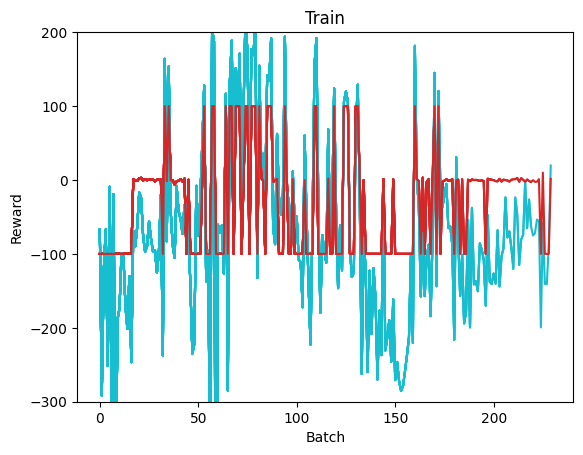

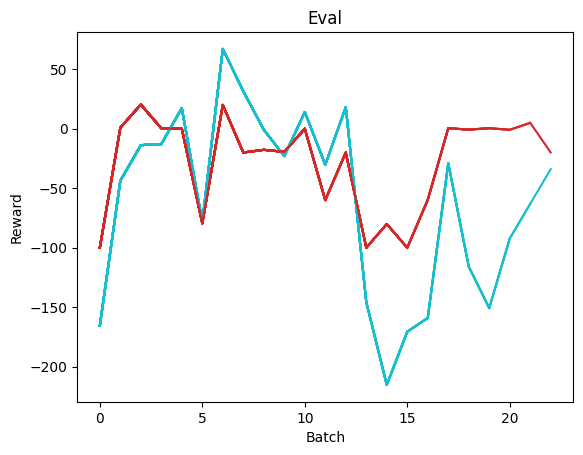

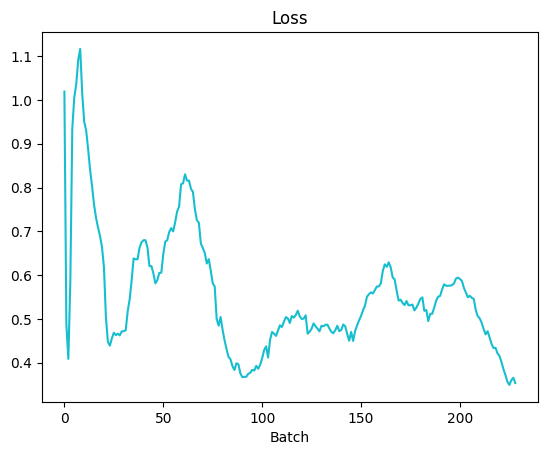

In [75]:
# %%capture
%matplotlib inline
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
def main():
  env = gym.make('LunarLander-v2')
  fix(env, seed) # fix the environment
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  train_eval(is_ipython,env,device,**save_load,**h_paras)
  # inference(env,device,**save_load,**h_paras)
main()

In [16]:
def inference(env,device,BUFFER_SIZE,LR,**kwargs):
  policy_net = Q_Network()
  target_net = Q_Network()
  target_net.load_state_dict(policy_net.state_dict())
  buffer = Buffer(BUFFER_SIZE)
  optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)

  agent = Q_Learning_Process(env,device,policy_net,target_net,buffer,optimizer)
  agent.policy_net.eval()
  agent.target_net.eval()
  NUM_OF_TEST = 1
  test_total_reward = []
  action_list = []

  total_rewards = []
  final_rewards = []
  for i in range(NUM_OF_TEST):
    actions = []
    state = env.reset()

    img = plt.imshow(env.render(mode='rgb_array'))

    total_reward = 0
    env_as_nparray = env.render(mode='rgb_array')
    img = plt.imshow(env_as_nparray)
    done = False

    while not done:
      input = torch.FloatTensor(state).unsqueeze(0).to(device)
      # action_one_hot = F.one_hot(torch.arange(0, 4))
      # input = torch.cat((input.repeat(4,1),action_one_hot.to(device)),dim = 1)
      # action = policy_net(input).max(0).indices.detach().item()
      input = torch.FloatTensor(state).unsqueeze(0).to(device)
      action = policy_net(input).max(1).indices.detach().item()
      img.set_data(env.render(mode='rgb_array'))
      display.display(plt.gcf())
      display.clear_output(wait=True)

      next_state, reward, done, info = env.step(action)
      total_reward += reward
      actions.append(action)
      if done:
        final_rewards.append(reward)

    total_reward.append(total_reward)
    action_list.append(actions)
  print(total_rewards)
  print(final_rewards)

In [ ]:
import matplotlib
matplotlib.get_backend()